<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Mixture Density Networks (MDN) for distribution and uncertainty estimation </h2>

This material is copyright Axel Brando and made available under the Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/). Code is also made available under the Apache Version 2.0 License (https://www.apache.org/licenses/LICENSE-2.0). 

Please, to use this material and code follow the instructions explained in the main repository [https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation](https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation#bibtex-reference-format-for-citation)

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>2D Regression problem</h3>

In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras import backend as K

import numpy as np

Using TensorFlow backend.


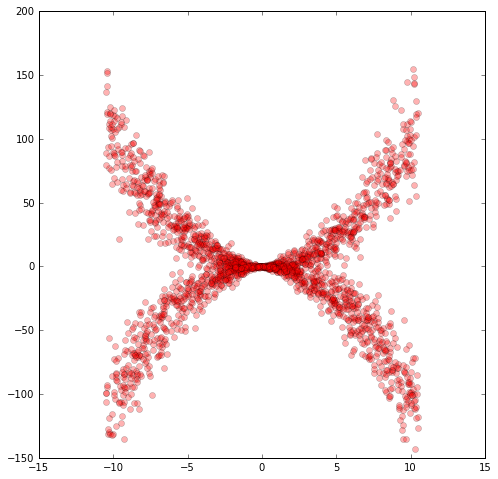

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math

NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE)))
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in x_data])
y_data = np.float32(np.square(x_data)+r_data*2.0)

x_data2 = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE)))
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in x_data2])
y_data2 = np.float32(-np.square(x_data2)+r_data2*2.0)

x_data = np.concatenate((x_data,x_data2),axis=1)
y_data = np.concatenate((y_data,y_data2),axis=1)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [51]:
#Imports of the Keras library parts we will need
from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras.objectives import mean_absolute_error

#Definition of the ELU+1 function
#With some margin to avoid problems of instability
from keras.layers.advanced_activations import ELU

def elu_modif(x, a=1.):
    e=1e-15
    return ELU(alpha=a)(x)+1.+e


c = 1 #The number of outputs we want to predict
m = 1 #The number of distributions we want to use in the mixture

#Note:80 The output size will be (c + 2) * m

def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max


def mean_log_Gaussian_like(y_true, parameters):
    """Mean Log Gaussian Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
    exponent = K.log(alpha) - .5 * float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(sigma) \
    - K.sum((K.expand_dims(y_true,2) - mu)**2, axis=1)/(2*(sigma)**2)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def mean_log_LaPlace_like(y_true, parameters):
    """Mean Log Laplace Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-2,1.))
    
    exponent = K.log(alpha) - float(c) * K.log(2 * sigma) \
    - K.sum(K.abs(K.expand_dims(y_true,2) - mu), axis=1)/(sigma)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


graph = Graph()
graph.add_input(name='input', input_shape=(1,))
graph.add_node(Dense(8, activation='relu'), name='dense1_1', input='input')
graph.add_node(Dropout(0.25), name='drop1_1', input='dense1_1')

graph.add_node(Dense(output_dim=c*m), name='FC_mus', input='drop1_1')
graph.add_node(Dense(output_dim=m, activation=elu_modif), name='FC_sigmas', input='drop1_1') #K.exp, W_regularizer=l2(1e-3)
graph.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='drop1_1')
graph.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graph
#Note 1: 'scoring_rule_adv' by  'mean_log_Gaussian_like' or
# 'mean_log_LaPlace_like' depending on your needs.
#Note 2: Replace 'rmsprop' by 'adam' depending on your needs.
graph.compile('rmsprop', {'output':mean_log_LaPlace_like})

In [5]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

NSAMPLE = 10000000
X = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE/2)))
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in X])
y = np.float32(np.square(X)+r_data*2.0)

X2 = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE/2)))
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in X2])
y2 = np.float32(-np.square(X2)+r_data2*2.0)

X = np.concatenate((X,X2),axis=1)
y = np.concatenate((y,y2),axis=1)

X = X.T
y = y.T

X,y = unison_shuffled_copies(X, y)

In [31]:
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
lossHistory = LossHistory()

In [61]:
from datetime import datetime
start_time = datetime.now()
epoch=120

graph.fit(data={'input':X,'output':y}, batch_size=1000000, nb_epoch=epoch, 
          validation_split=0.1,callbacks=[lossHistory], verbose=0) #[np.tile(y,(1,c*m)),y] 
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  End  *********************************

Duration: 0:14:42.863829


### Testing the trained model

In [11]:
NSAMPLE = 1000
X_val = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE/2)))
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in X_val])
#np.float32(np.random.normal(size=(NSAMPLE,1)))
y_val = np.float32(np.square(X_val)+r_data*2.0)

X_val2 = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE/2)))
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in X_val2])
#np.float32(np.random.normal(size=(NSAMPLE,1)))
y_val2 = np.float32(-np.square(X_val2)+r_data2*2.0)

X_val = np.concatenate((X_val,X_val2),axis=1)
y_val = np.concatenate((y_val,y_val2),axis=1)

X_val = X_val.T
y_val = y_val.T

X_val,y_val = unison_shuffled_copies(X_val, y_val)

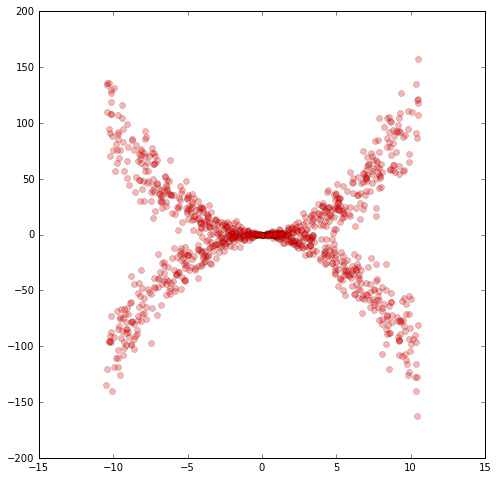

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plot_out = plt.plot(X_val,y_val,'ro',alpha=0.3)
plt.show()

### Results obtained in mean_log_LaPlace_like case

Absolute error 36689.7


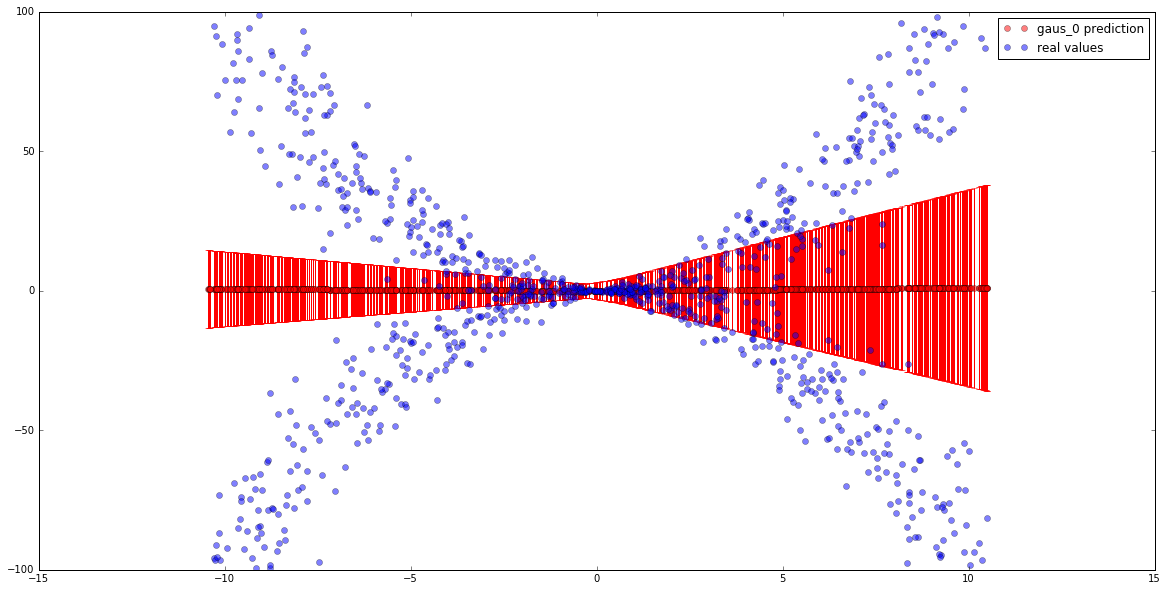

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 36686.0


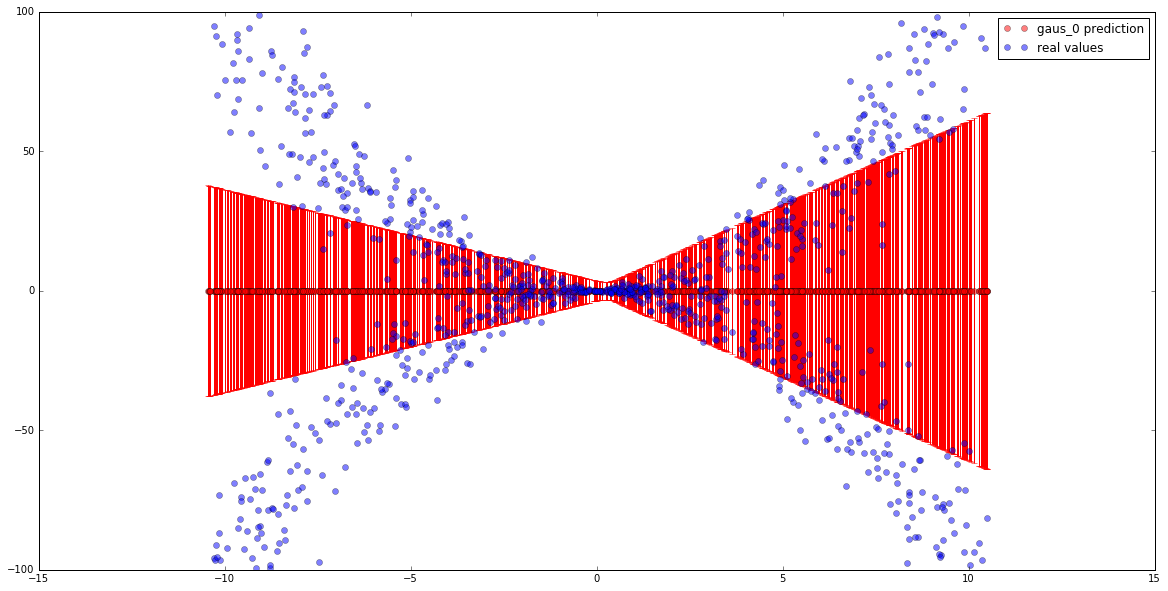

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 36686.6


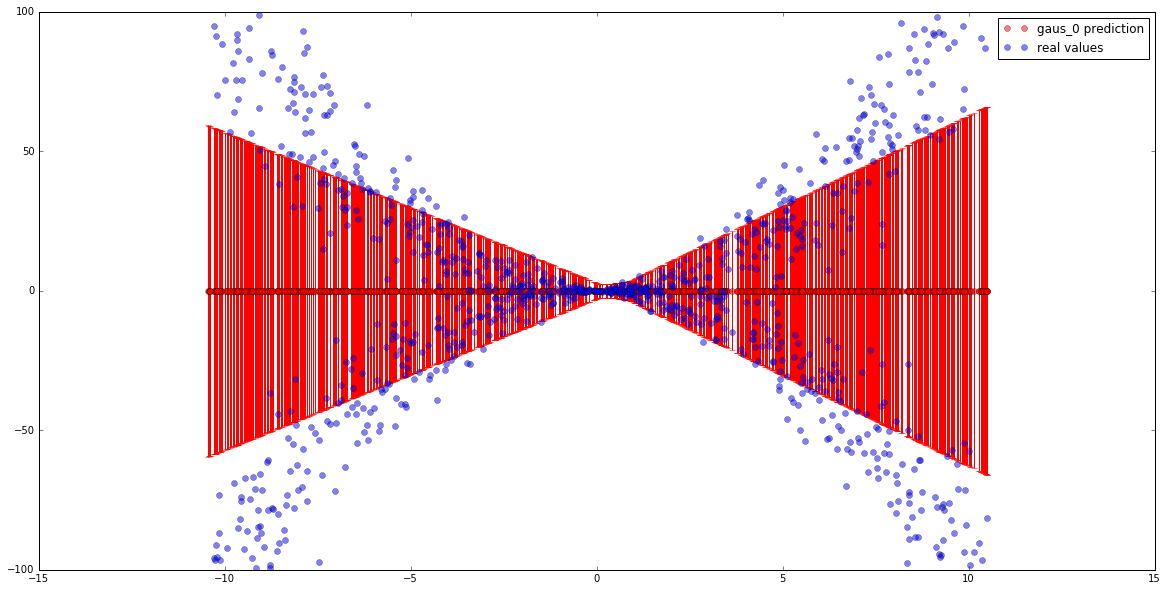

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 36691.1


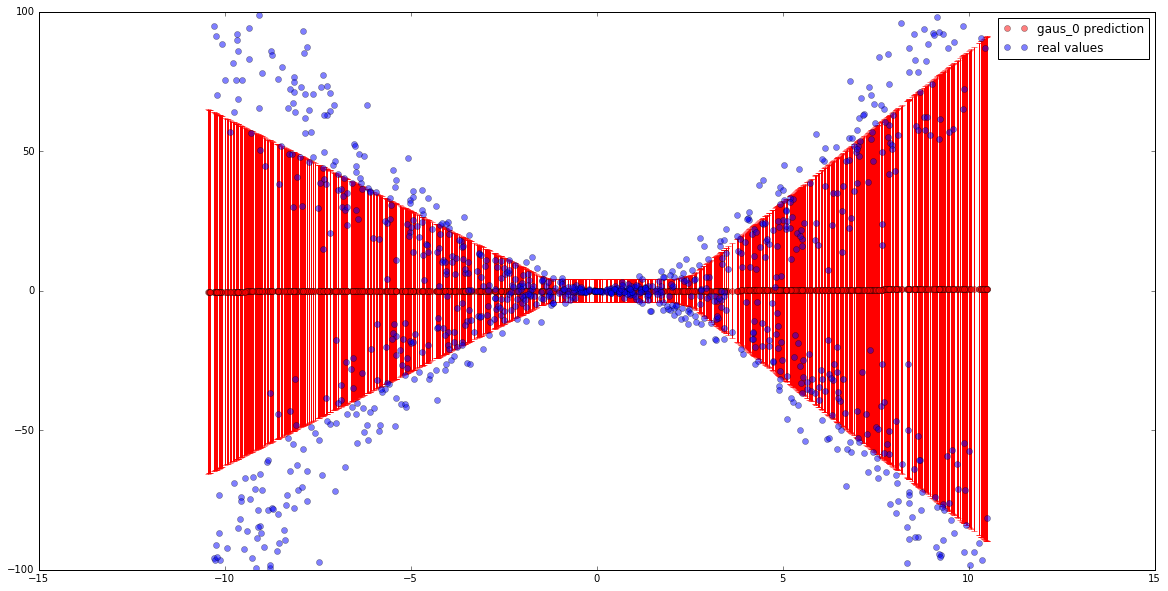

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 36694.5


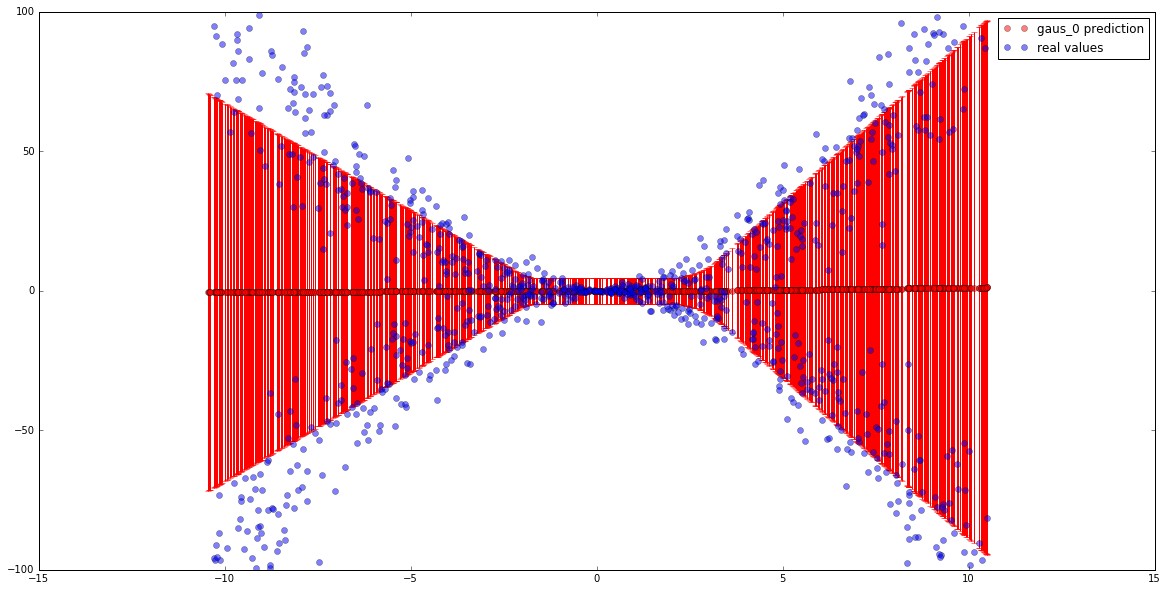

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

### Results in the mean_log_G_like case

Absolute error 36680.8


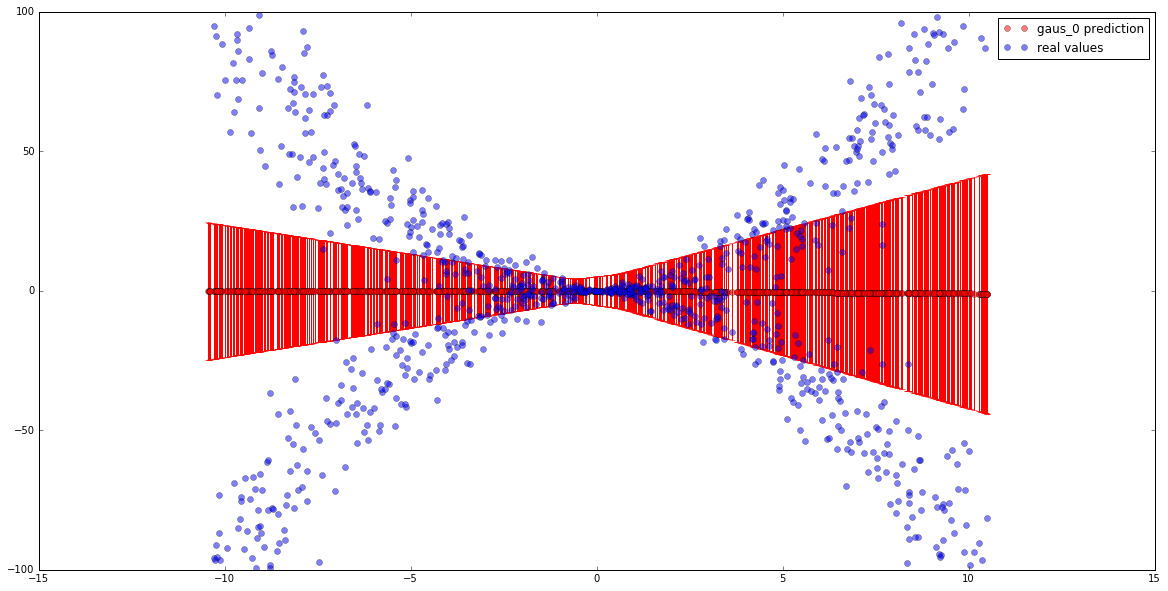

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 36686.6


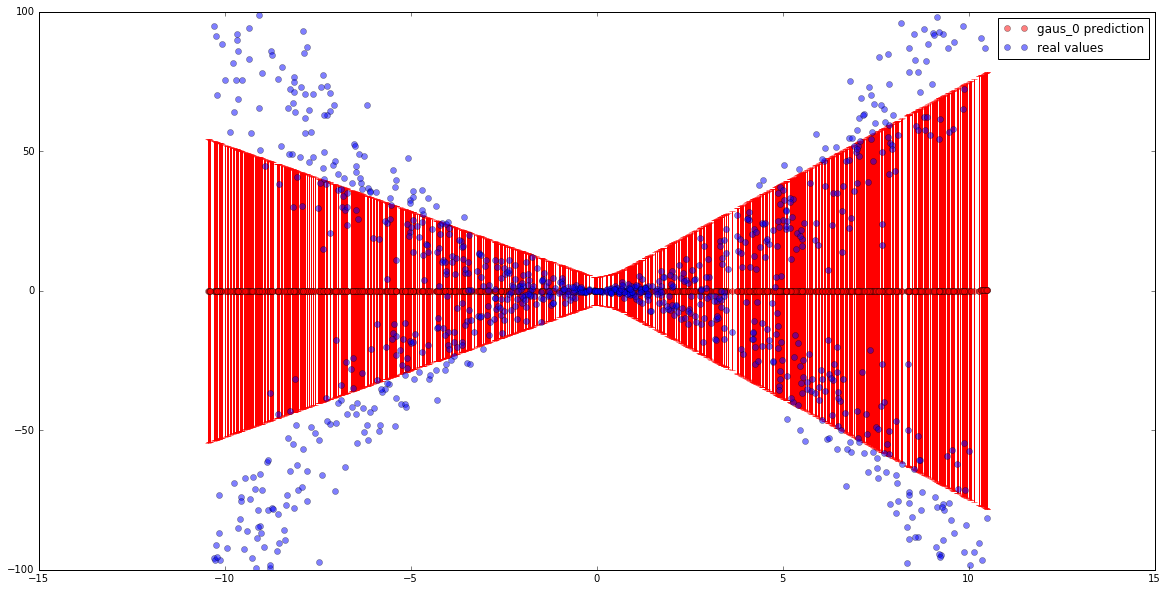

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 36686.1


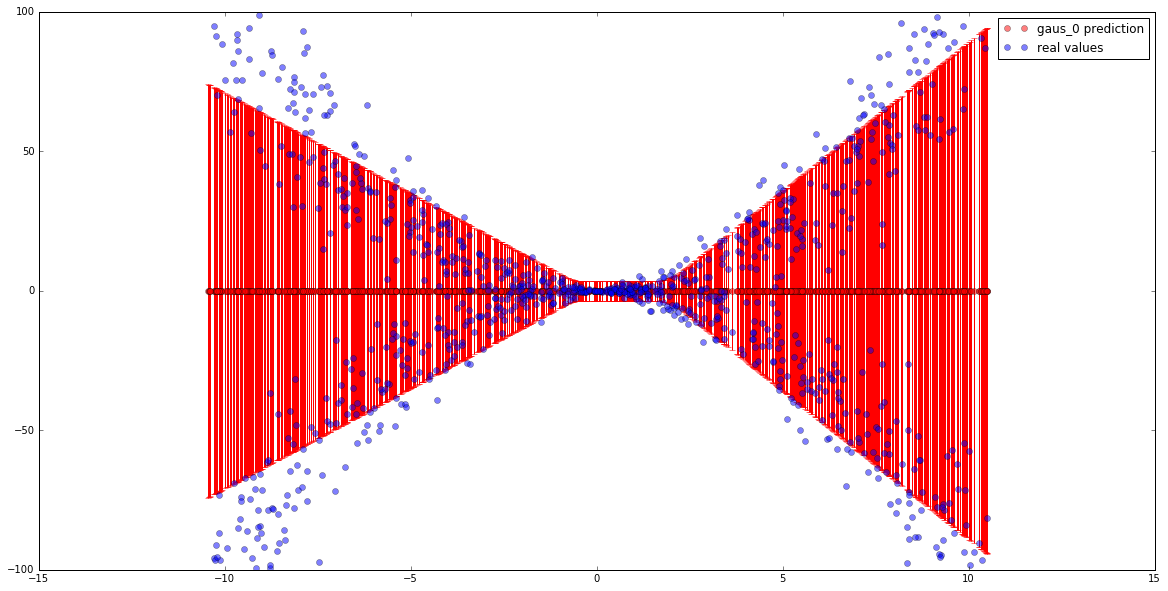

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

### Results obtained by using 2-Gaussian distribution mixture model.

Absolute error 32718.0


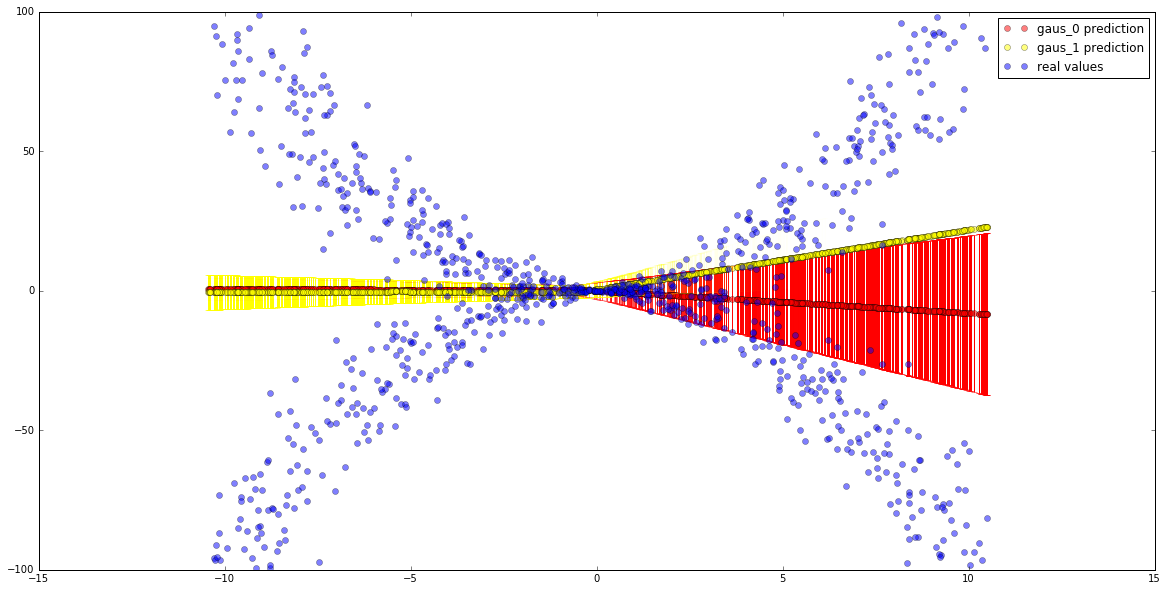

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 26278.6


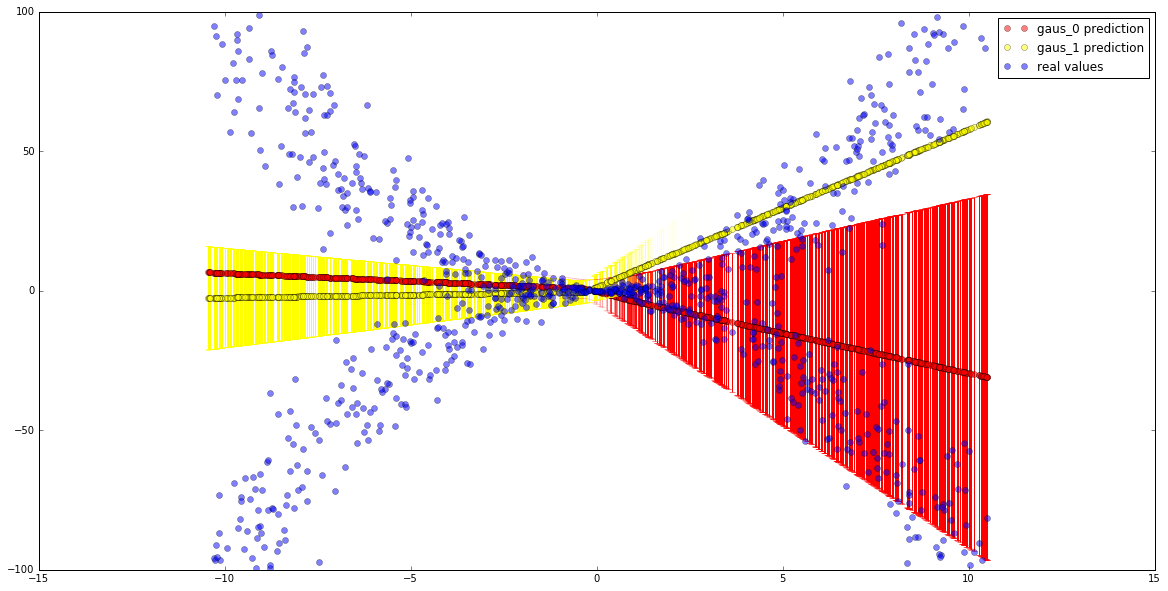

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 20730.9


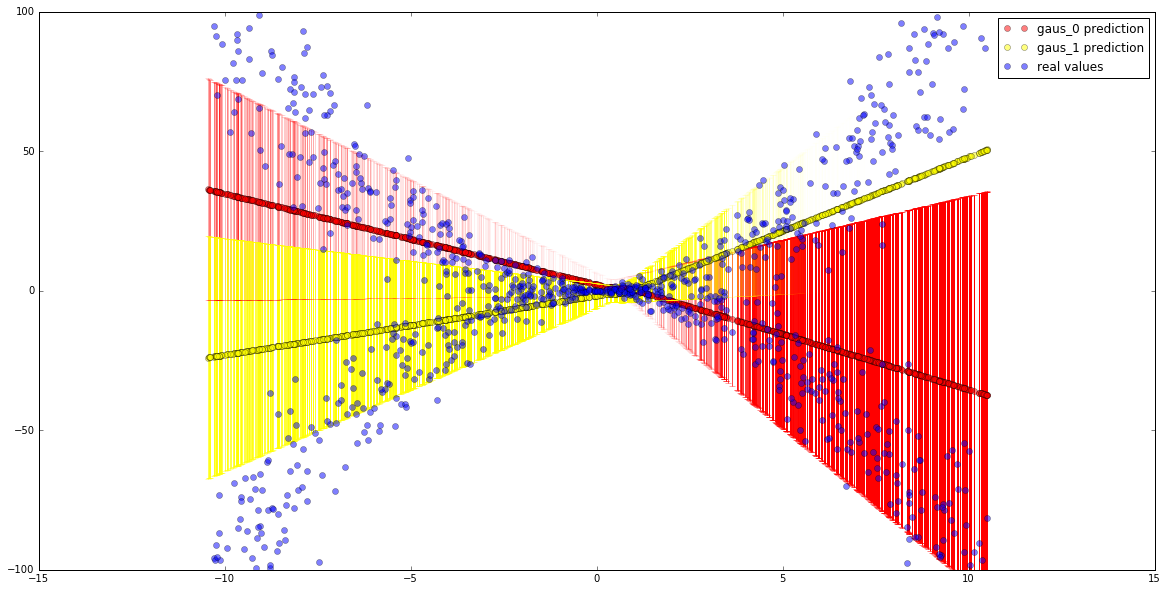

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 15514.0


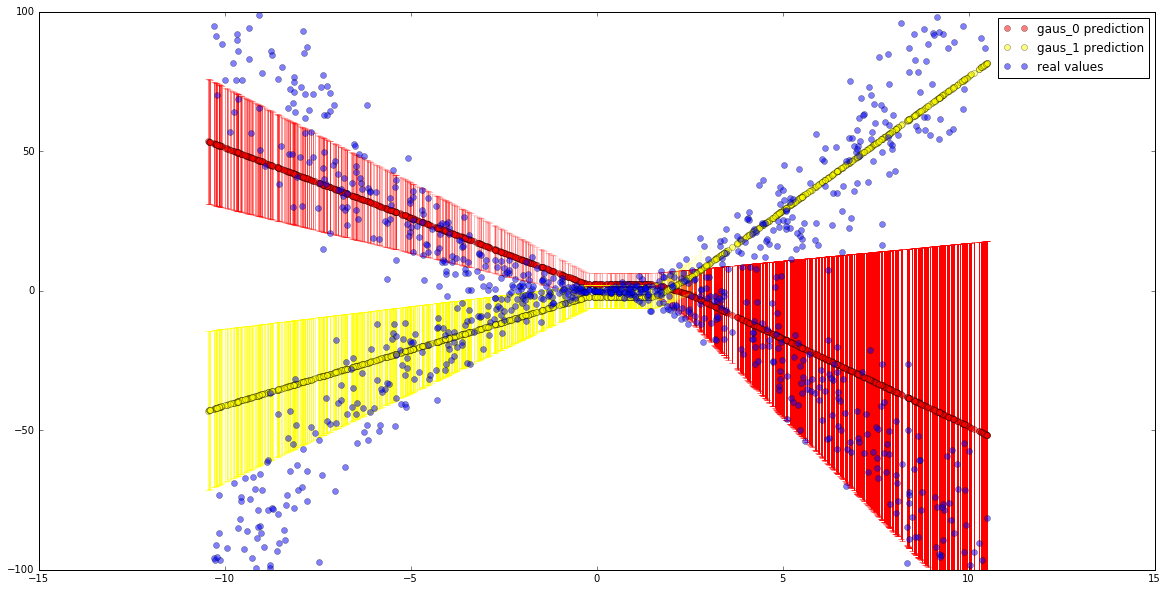

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 14131.8


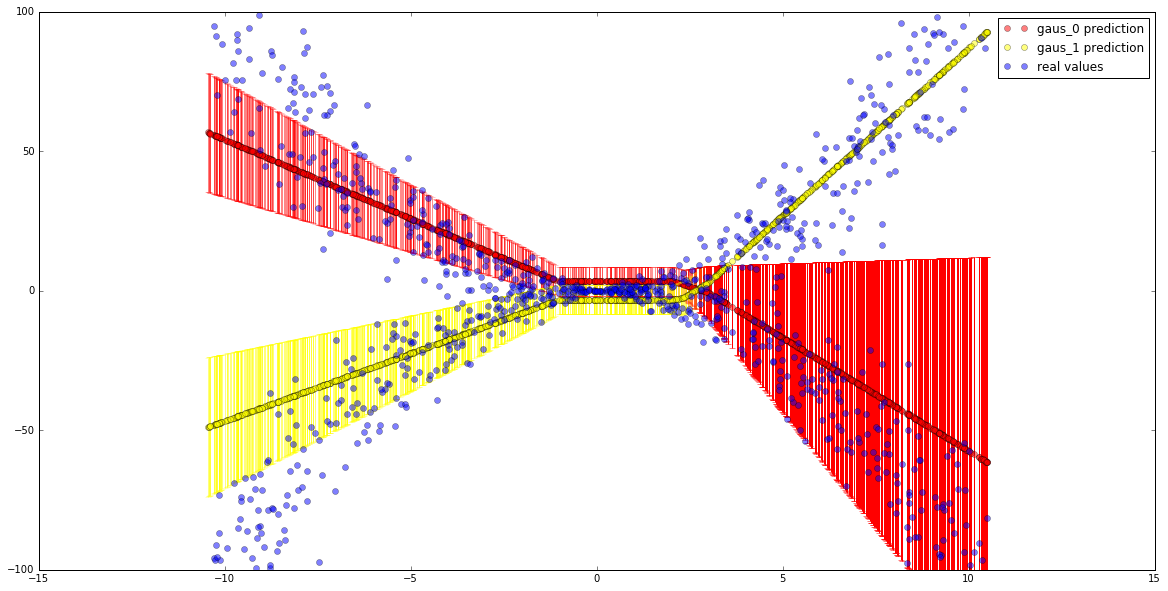

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

### Results obtained by using Laplacian distribution mixture model.

Absolute error 31170.8


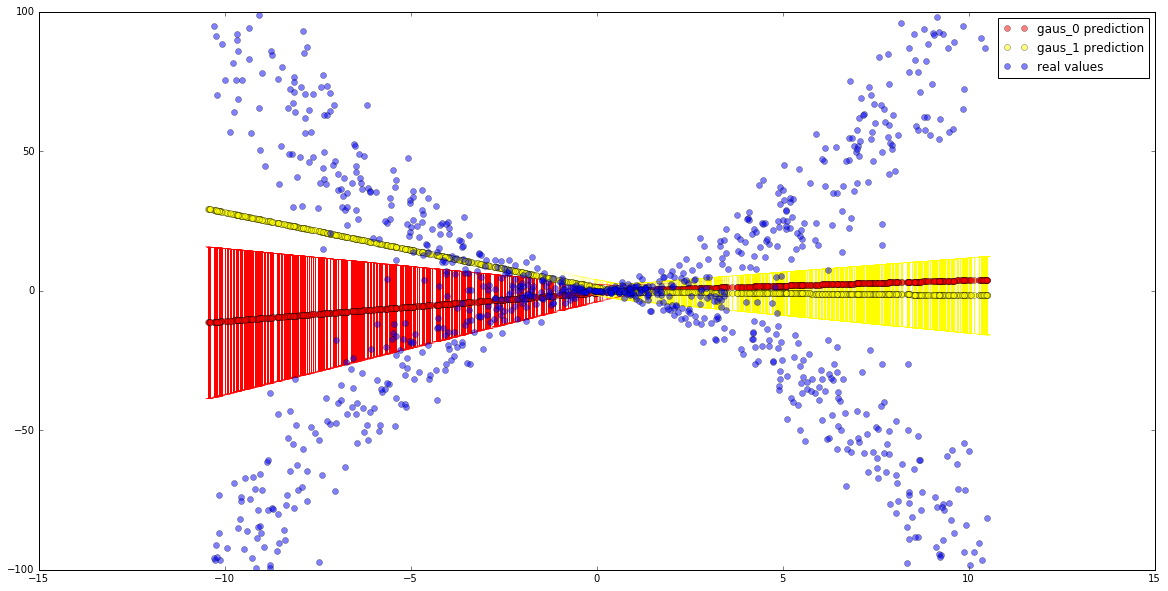

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 23638.1


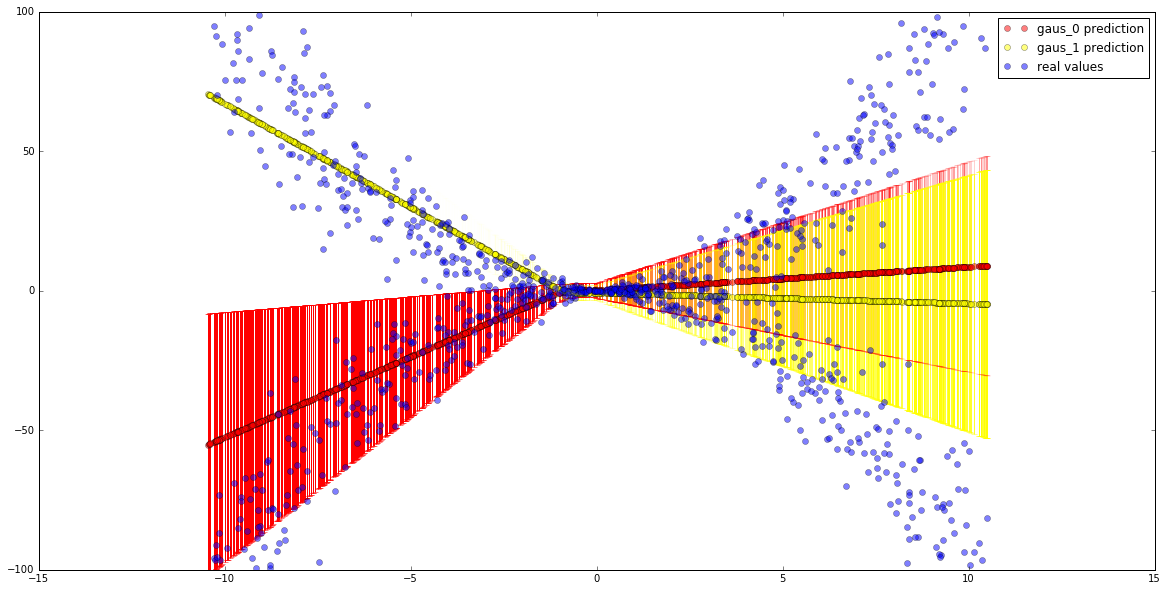

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 14900.2


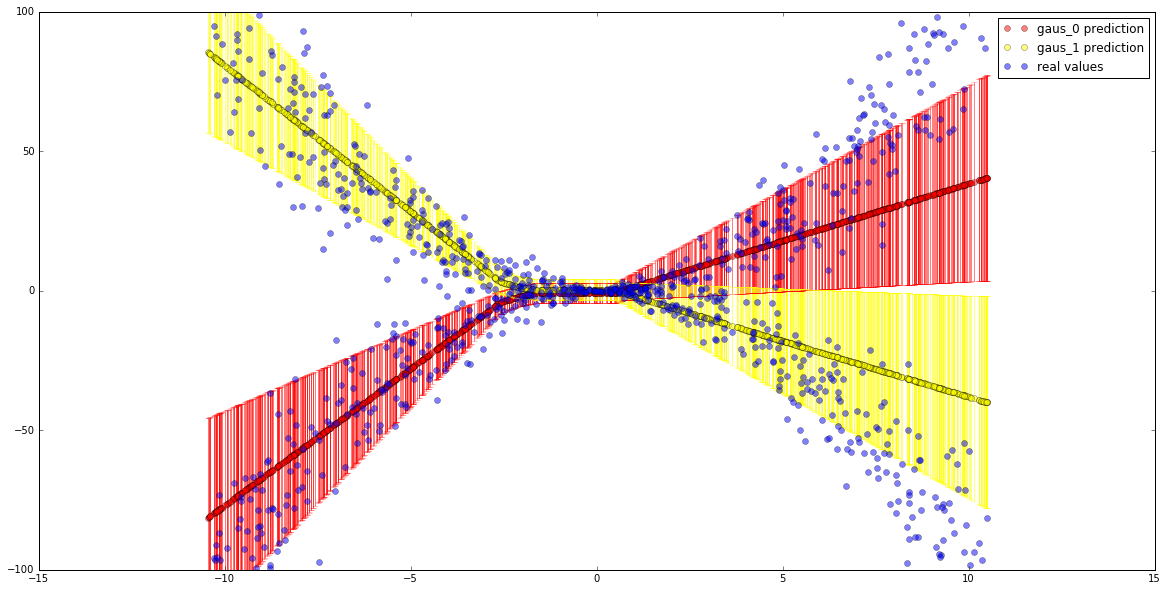

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 12174.2


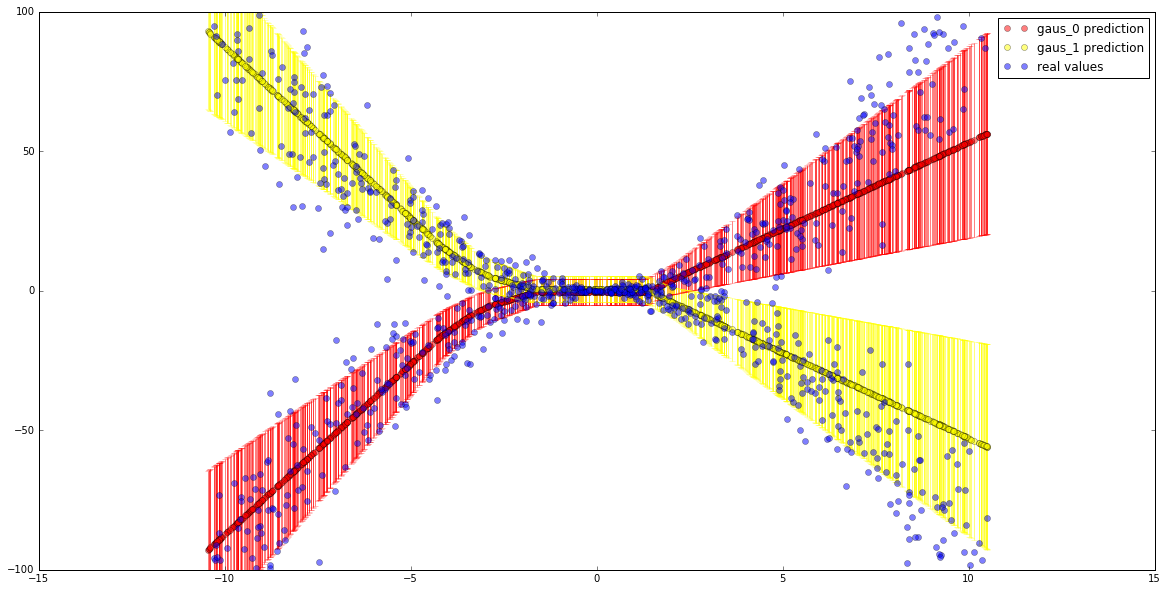

In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

### Results obtained by using 10 Laplacians distributions mixture model

Absolute error 20787.4


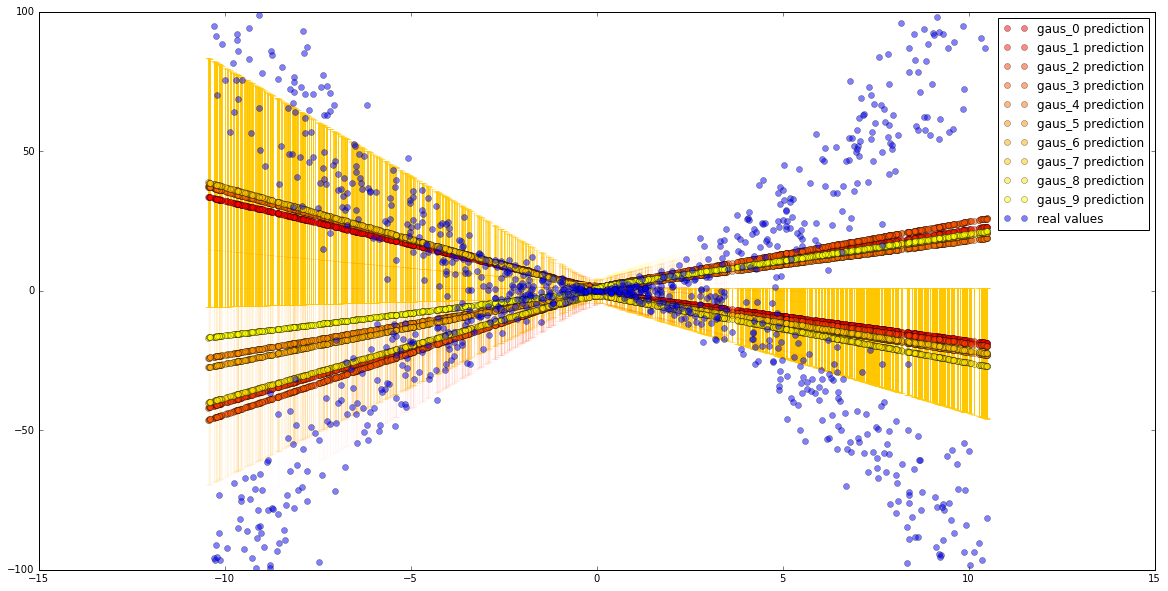

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 6046.39


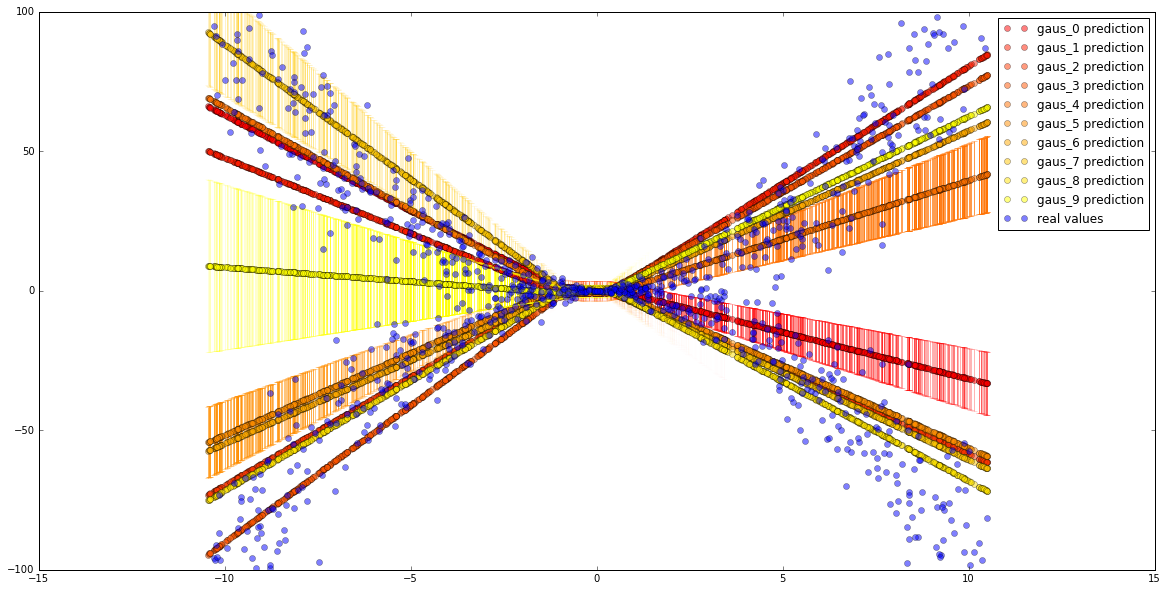

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 4963.6


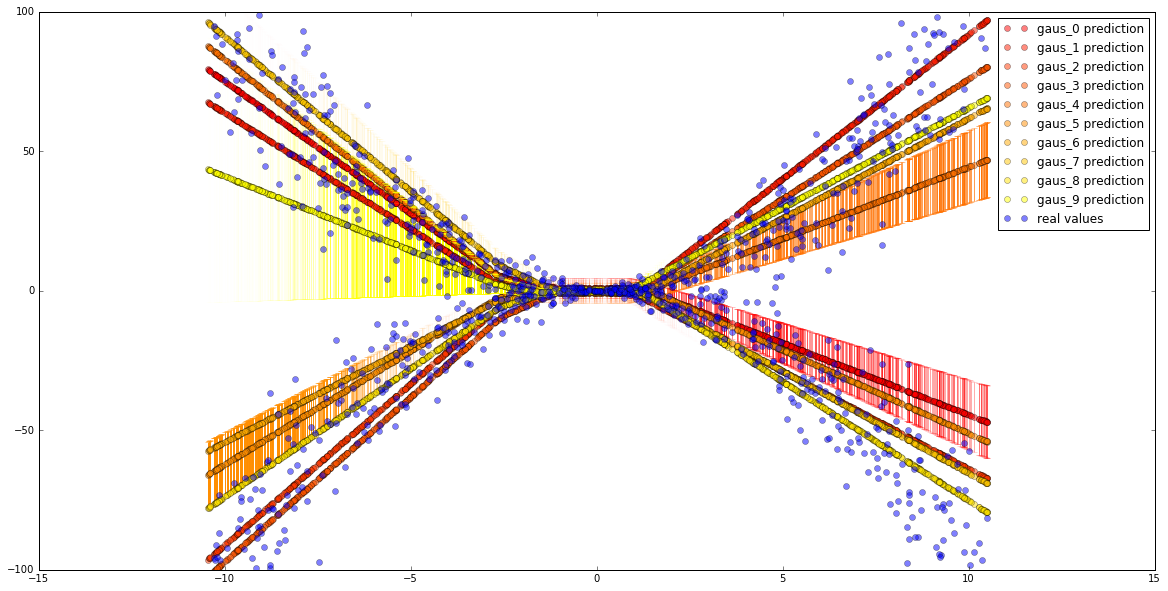

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

### Visualisation of the probability density function as a heat graphic for 2D problems.

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


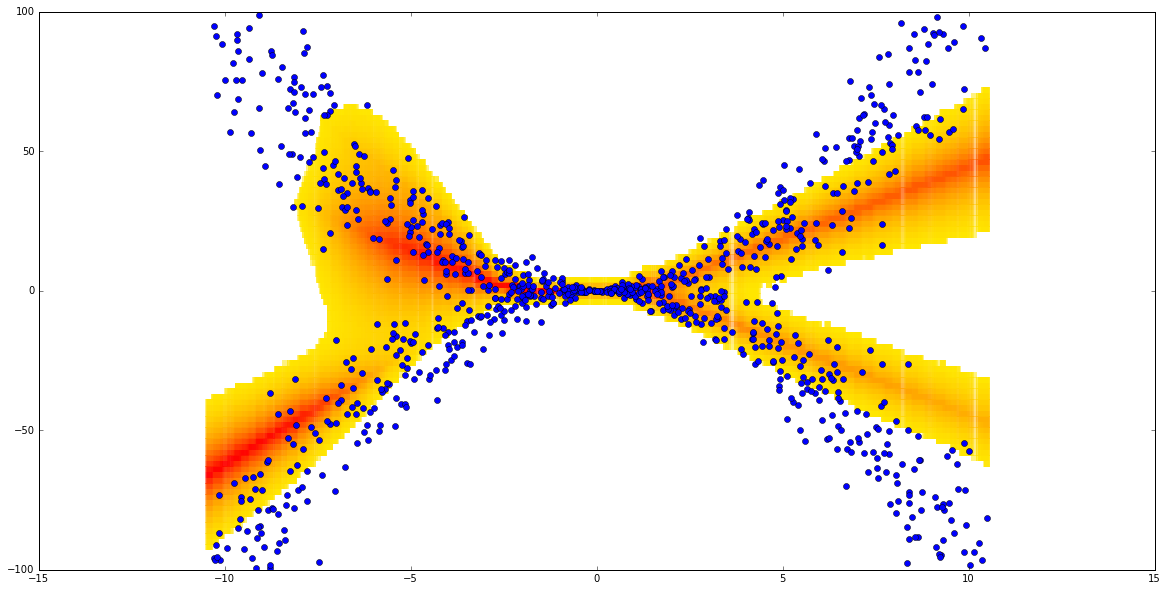

In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines

import matplotlib.cm as cm

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

def LaPlacePDF(x,mu,b):
    return np.exp(-np.abs(x-mu)/b)/(2*b)

colors = cm.autumn(np.linspace(0, 1, 100))[::-1]

points = np.arange(-v_rang,v_rang,v_rang/50)

for i in xrange(len(mu_pred)):
    pdf = np.zeros_like(points,dtype='float64')
    for mx in xrange(mu_pred.shape[-1]):
        tmp_pdf = LaPlacePDF(points,mu_pred[i,0,mx],sigma_pred[i,mx])
        pdf += alpha_pred[i,mx]*(tmp_pdf/np.max(tmp_pdf))
        
    for p in xrange(len(points)):
        if round(pdf[p]*100) > 10:
            plt.plot(X_val[i], points[p], marker='s', 
                     linewidth=1, linestyle='None', 
                     color=colors[round(pdf[p]*100)-1], 
                     alpha=0.5, markeredgewidth=0.0)
        
pyplot.plot(X_val,y_val, 
            color='blue', linewidth=1, marker='o', 
            linestyle=' ',alpha=1)

axes = pyplot.gca()
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))

### More iterations of the same process

Absolute error 4595.95


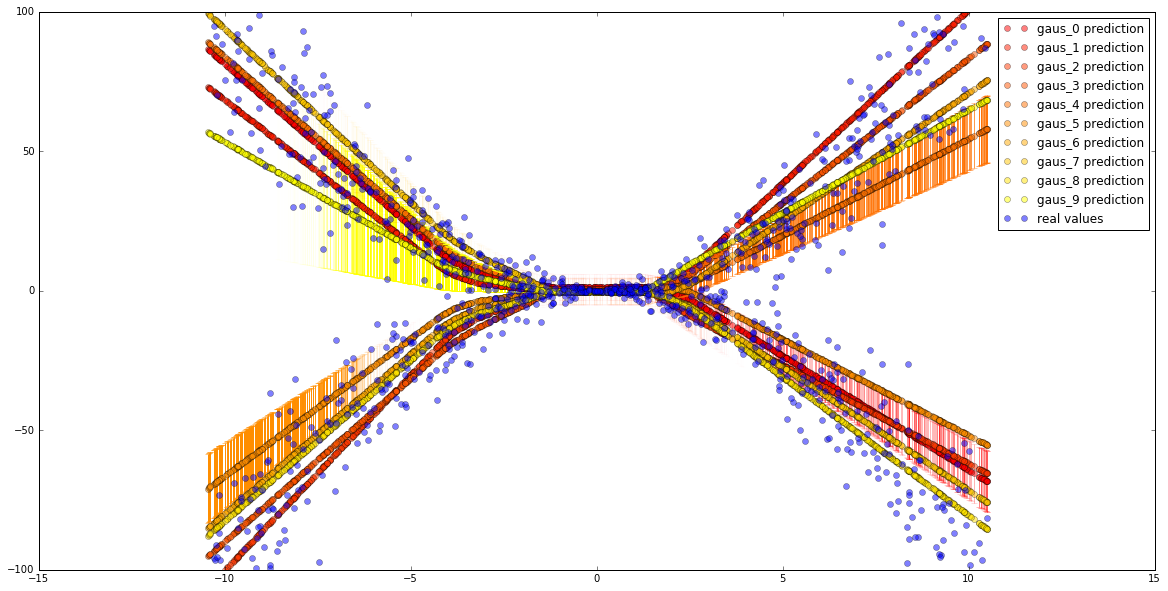

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
v_rang = 100

parameters = graph.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx)+" prediction")
    
pyplot.plot(X_val,y_val, color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='real values')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


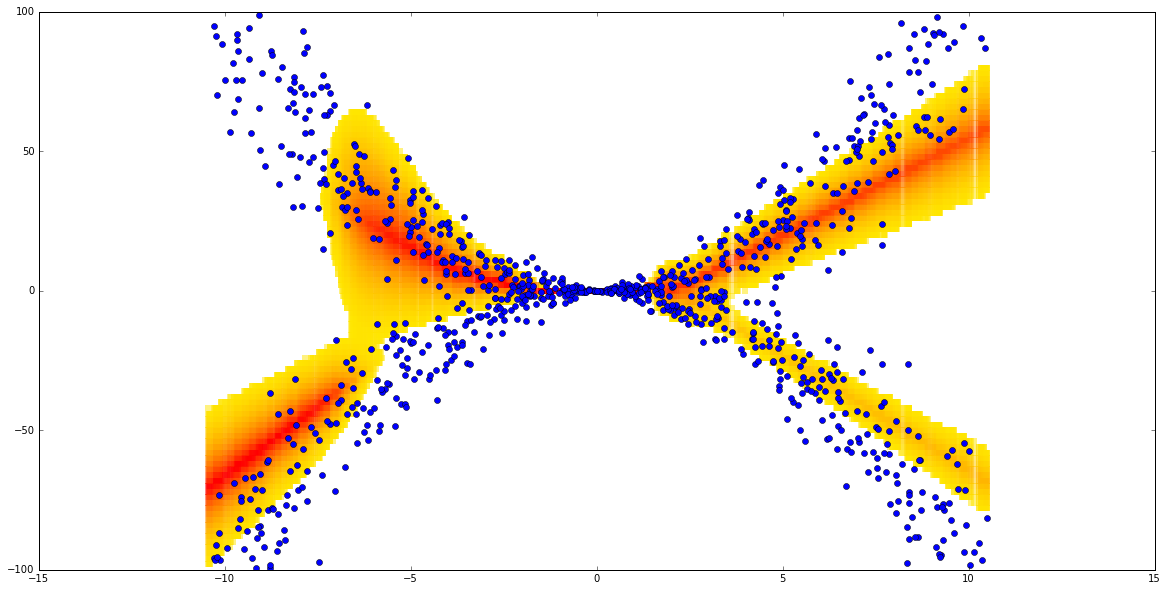

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines

import matplotlib.cm as cm

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

def LaPlacePDF(x,mu,b):
    return np.exp(-np.abs(x-mu)/b)/(2*b)

colors = cm.autumn(np.linspace(0, 1, 100))[::-1]

points = np.arange(-v_rang,v_rang,v_rang/50)

for i in xrange(len(mu_pred)):
    pdf = np.zeros_like(points,dtype='float64')
    for mx in xrange(mu_pred.shape[-1]):
        tmp_pdf = LaPlacePDF(points,mu_pred[i,0,mx],sigma_pred[i,mx])
        pdf += alpha_pred[i,mx]*(tmp_pdf/np.max(tmp_pdf))
        
    for p in xrange(len(points)):
        if round(pdf[p]*100) > 10:
            plt.plot(X_val[i], points[p], marker='s', 
                     linewidth=1, linestyle='None', 
                     color=colors[round(pdf[p]*100)-1], 
                     alpha=0.5, markeredgewidth=0.0)
        
pyplot.plot(X_val,y_val, 
            color='blue', linewidth=1, marker='o', 
            linestyle=' ',alpha=1)

axes = pyplot.gca()
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


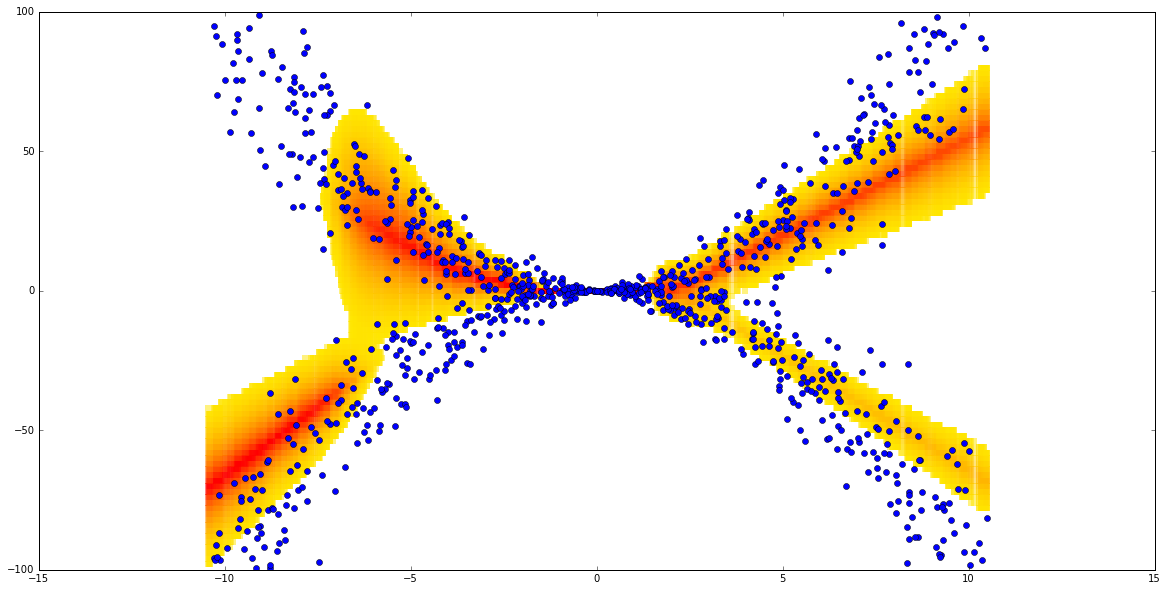

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
from tqdm import tqdm

import matplotlib.cm as cm

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

def LaPlacePDF(x,mu,b):
    return np.exp(-np.abs(x-mu)/b)/(2*b)

colors = cm.autumn(np.linspace(0, 1, 100))[::-1]

points = np.arange(-v_rang,v_rang,v_rang/50)

for i in tqdm(xrange(len(mu_pred))):
    pdf = np.zeros_like(points,dtype='float64')
    for mx in xrange(mu_pred.shape[-1]):
        tmp_pdf = LaPlacePDF(points,mu_pred[i,0,mx],sigma_pred[i,mx])
        pdf += alpha_pred[i,mx]*(tmp_pdf/np.max(tmp_pdf))
        
    for p in xrange(len(points)):
        if round(pdf[p]*100) > 10:
            plt.plot(X_val[i], points[p], marker='s', 
                     linewidth=1, linestyle='None', 
                     color=colors[round(pdf[p]*100)-1], 
                     alpha=0.5, markeredgewidth=0.0)
        
pyplot.plot(X_val,y_val, 
            color='blue', linewidth=1, marker='o', 
            linestyle=' ',alpha=1)

axes = pyplot.gca()
axes.set_ylim(-v_rang,v_rang)
pyplot.gcf().set_size_inches((20,10))